# Ranked-batch Active Learning with Open-set

Authors: Domicio Neto, Sérgio Machado

This notebook contains the code used to test our approach. Here it is possible to train and test an Active Learner with a modified K-Nearest Neighbors estimator and with a Ranked Batch query strategy. 

It is possible to change and test other configurations, including modifying the batch size and the number of samples to be queried by the Active Learner and compare it to a baseline knn classifier.

In [1]:
import numpy as np
import math

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from functools import partial
from modAL.batch import uncertainty_batch_sampling

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

from openkneighbors import KNeighborsClassifierOpenSet

Place the **openkneighbors.py** script and the **cifar-10-batches-py** folder in the directory of this notebook.

### Experiment parameters

You might want to change these parameters to reproduce our results or test your own configurations. Feel free to change other parts in this script.

In [2]:
parameters = [[25,621],[25,984],[25,162],[25,344],[25,156],
             [50,420],[50,367],[50,713],[50,248],[50,330],
             [100,551],[100,807],[100,914],[100,819],[100,851],
             [250,731],[250,591],[250,606],[250,498],[250,296]]
p_idx = 0

In [3]:
# remember, the number of samples to be queried must be divisible by the batch size
BATCH_SIZE, RANDOM_STATE_SEED = parameters[p_idx]
N_SAMPLES = 500
N_QUERIES = int(N_SAMPLES/BATCH_SIZE)

In [4]:
print("Batch size: "+str(BATCH_SIZE))
print("Number of queries: "+str(N_QUERIES))
print("Seed: "+str(RANDOM_STATE_SEED))

Batch size: 25
Number of queries: 20
Seed: 621


### Setting the seed to reproduce the same results

In [5]:
np.random.seed(RANDOM_STATE_SEED)

### Auxiliary functions

In [6]:
# for importing the cifar10 dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
# returns an image data, its label and the label's name of the image at index im_idx
def cifar10_img_info(data, meta, im_idx=0):
    im = data[b'data'][im_idx, :]

    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    label = data[b'labels'][im_idx]
    category = meta[b'label_names'][data[b'labels'][im_idx]]

    return img, label, category

In [8]:
# reshapes a image from a row vector to a rgb array
def img_reshape(im):
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    
    return img

In [9]:
# separates the samples and the labels from the batch to the X and y variables
def batch_to_xy(batch):
    X = batch[b"data"]
    y = batch[b"labels"]
    y = np.array(y)
    y.reshape(y.shape[0])
    return X, y

### Importing and preparing the dataset

In [10]:
# batch with 10000 examples
batch1 = unpickle("cifar-10-batches-py/data_batch_1")
# meta has the labels' names
meta = unpickle("cifar-10-batches-py/batches.meta")

#### Example from the dataset

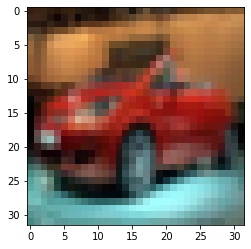

In [11]:
# change img_idx to see another example
img_idx = 45
img_ex, label_ex, category_ex = cifar10_img_info(batch1, meta, img_idx)
plt.imshow(img_ex)

In [12]:
print("Label: "+str(label_ex)+"\nCategory: "+str(category_ex))

Label: 1
Category: b'automobile'


#### Preparing the samples and labels

First we separate the samples and labels from the raw dataset.

In [13]:
X_default, Y_default = batch_to_xy(batch1)

Since we have 32 x 32 rgb images, we get 32 x 32 x 3 = 3072 features.

In [14]:
# X_default shape is number of samples x number of features
print(X_default.shape)

(10000, 3072)


In [15]:
# labels
print(Y_default.shape)

(10000,)


#### Feature reduction 

We use PCA to reduce our number of features to 99 in order to optimize the training process.

In [16]:
pca = PCA(n_components=99, random_state=RANDOM_STATE_SEED)
tf_X = pca.fit_transform(X=X_default)

In [17]:
tf_X.shape

(10000, 99)

In [18]:
X_default = tf_X

#### Separating classes from our dataset to work as unknown classes

For our study, we removed the two last classes from our dataset to create a second dataset for training the active learner. We still use the full dataset to evaluate the learner's open set performance by changing the true labels of the samples that were removed to -1. If the learner predicts a sample's label as being -1 it means the sample was considered to be from an unknown class.

In [19]:
# now we remove two classes from the dataset
# first class to be removed
unknown1 = 8
# second class to be removed
unknown2 = 9
u1_idx = Y_default == unknown1
u2_idx = Y_default == unknown2
u_idx = u1_idx + u2_idx
# new dataset with the remaining classes
X_closed = np.delete(X_default, u_idx, axis=0)
Y_closed = np.delete(Y_default, u_idx, axis=0)

In [20]:
# Y_open is the modified version of the true labels. Now -1 represents the rejected unknown samples.
Y_open = Y_default
# -1 is the unknown class label
Y_open[u_idx] = -1;

### Creating the training sets

Now we create the training sets for the active learner and for the baseline classifier. We defined a 75% training split for the training set and a 90% split for the baseline.

Both the active learner and baseline classifier are trained with the closed dataset without the unknown classes, those are only used for testing.

In [21]:
# training set for the active learner
n_labeled = X_closed.shape[0]   #Number of samples
training_indices = np.random.randint(low=0, high=n_labeled, size=int(n_labeled*0.75))

In [22]:
X_train = X_closed[training_indices]
y_train = Y_closed[training_indices]
X_train.shape

(5995, 99)

In [23]:
# this is the pool where the active learner will query new samples
X_pool = np.delete(X_closed, training_indices, axis=0)
y_pool = np.delete(Y_closed, training_indices, axis=0)

In [24]:
X_pool.shape

(3752, 99)

In [25]:
# training set for the baseline classifier
n_labeled_baseline = X_closed.shape[0]
training_indices_baseline = np.random.randint(low=0, high=n_labeled_baseline, size=int(n_labeled_baseline*0.90))
X_train_baseline = X_closed[training_indices_baseline]
y_train_baseline = Y_closed[training_indices_baseline]
print(X_train_baseline.shape)

(7194, 99)


### Creating the baseline classifier

The baseline is a KNN classifier modified to reject unknown classes, also used as the active learner's estimator. The baseline classifier will be trained with 90% of the closed set dataset and will not go through the active learning loop. We calculate the micro-F1 score for both closed and open set performances. 

In [26]:
knn_default = KNeighborsClassifierOpenSet(n_neighbors_os=3, weights_os='distance')
# training the classifier
knn_default.fit(X_train_baseline, y_train_baseline)

In [27]:
baseline_score = knn_default.f1_score(X_closed, Y_closed)
print("Baseline closed set score: "+str(baseline_score))

Baseline closed set score: 0.7267950963222417


In [28]:
# the threshold is equal to the score on the closed set
knn_default.set_threshold(baseline_score)
baseline_score_open = knn_default.f1_score_open(X_default, Y_open)
print("Baseline open set score: "+str(baseline_score_open))

Baseline open set score: 0.6543


### Initializing the learner

In [29]:
knn = KNeighborsClassifierOpenSet(n_neighbors_os=3, weights_os='distance')

In [30]:
# pre-set our batch sampling to retrieve BATCH_SIZE samples at a time
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

In [31]:
# creating the active learner
learner = ActiveLearner(
    estimator=knn,
    X_training=X_train,
    y_training=y_train,
    query_strategy=preset_batch
)

In [32]:
# closed set score
closed_set_score = learner.estimator.f1_score(X_closed, Y_closed)
performance_history = [closed_set_score]
print("Closed set score: "+str(closed_set_score))

Closed set score: 0.6768826619964974


In [33]:
# setting the open set classifier threshold
learner.estimator.set_threshold(closed_set_score)

In [34]:
# open set score
open_score = learner.estimator.f1_score_open(X_default, Y_open)
open_performance_history = [open_score]
print("Open set score: "+str(open_score))

Open set score: 0.6017


### Active learning loop

Here is where the Active Learning happens. At each iteration, the learner queries a batch of samples and receives the correct labels. Then the learner trains the estimator again with the new learned samples. Finally, we calculate the performance on the closed and open sets in each iteration.

In [35]:
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # teach our ActiveLearner model the batch it has requested
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # remove the queried instances from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # calculate our model's closed set performance
    model_f1_score = learner.estimator.f1_score(X_closed, Y_closed)
    # updating the threshold
    learner.estimator.set_threshold(model_f1_score)
    # calculate our model's open set performance
    model_open_f1_score = learner.estimator.f1_score_open(X_default, Y_open)
    print('Closed set accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_f1_score))
    print('Open set accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_open_f1_score))
    # save our model's performance for plotting
    performance_history.append(model_f1_score)
    open_performance_history.append(model_open_f1_score)

Closed set accuracy after query 1: 0.6794
Open set accuracy after query 1: 0.6070
Closed set accuracy after query 2: 0.6823
Open set accuracy after query 2: 0.6113
Closed set accuracy after query 3: 0.6846
Open set accuracy after query 3: 0.6149
Closed set accuracy after query 4: 0.6879
Open set accuracy after query 4: 0.6187
Closed set accuracy after query 5: 0.6903
Open set accuracy after query 5: 0.6215
Closed set accuracy after query 6: 0.6925
Open set accuracy after query 6: 0.6243
Closed set accuracy after query 7: 0.6953
Open set accuracy after query 7: 0.6268
Closed set accuracy after query 8: 0.6979
Open set accuracy after query 8: 0.6295
Closed set accuracy after query 9: 0.7004
Open set accuracy after query 9: 0.6317
Closed set accuracy after query 10: 0.7025
Open set accuracy after query 10: 0.6342
Closed set accuracy after query 11: 0.7052
Open set accuracy after query 11: 0.6368
Closed set accuracy after query 12: 0.7079
Open set accuracy after query 12: 0.6395
Closed set

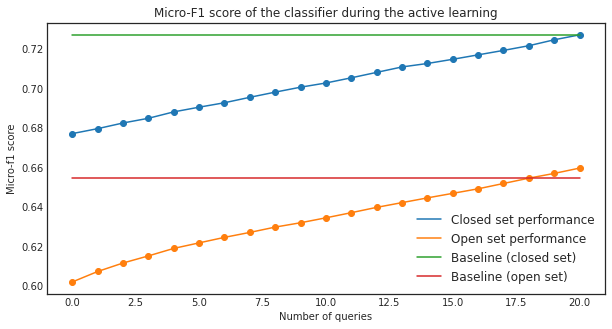

In [36]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Micro-F1 score of the classifier during the active learning')    
    plt.plot(range(N_QUERIES+1), performance_history)
    plt.scatter(range(N_QUERIES+1), performance_history)
    plt.plot(range(N_QUERIES+1), open_performance_history)
    plt.scatter(range(N_QUERIES+1), open_performance_history)
    plt.plot(range(N_QUERIES+1), np.repeat(baseline_score, N_QUERIES+1))
    plt.plot(range(N_QUERIES+1), np.repeat(baseline_score_open, N_QUERIES+1))
    plt.legend(['Closed set performance','Open set performance','Baseline (closed set)','Baseline (open set)'], fontsize = 'large')
    plt.xlabel('Number of queries')
    plt.ylabel('Micro-f1 score')
    plt.show()

### Threshold comparison

We have chosen to define dynamically our estimator threshold as the estimator's closed set performance. Below we can compare it to other possible thresholds using our already trained estimator.

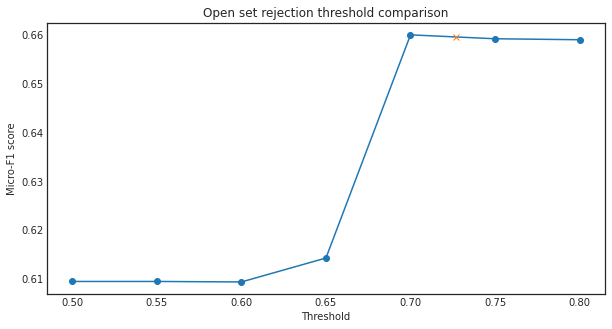

In [37]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
results = []
default_threshold = learner.estimator.threshold
for thresh in thresholds:
    learner.estimator.set_threshold(thresh)
    open_score = learner.estimator.f1_score_open(X_default, Y_open)
    results.append(open_score)
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Open set rejection threshold comparison')
    plt.plot(thresholds, results)
    plt.plot(default_threshold, open_performance_history[-1], 'x')
    plt.scatter(thresholds, results)
    plt.xlabel('Threshold')
    plt.ylabel('Micro-F1 score')
    plt.show()

### Unknown class detection

Here we evaluate our approach's capacity of rejecting the unknown classes.

In [38]:
# this dataset only has the unknown samples
X_unknown = X_default[u_idx]
y_unknown = Y_open[u_idx]

In [39]:
print("Number of unknown samples: "+str(X_unknown.shape[0]))

Number of unknown samples: 2006


In [40]:
unknown_classes_prediction = learner.estimator.predict_open(X_unknown)
is_correct = unknown_classes_prediction == y_unknown
correct = np.count_nonzero(is_correct)
print("Rejected samples: "+str(correct))

Rejected samples: 1414


In [41]:
rej_acc = correct/X_unknown.shape[0]
print("Rejection accuracy: "+str(rej_acc))

Rejection accuracy: 0.7048853439680958


Baseline performance

In [42]:
baseline_pred = knn_default.predict_open(X_unknown)
baseline_is_correct = baseline_pred == y_unknown
baseline_correct = np.count_nonzero(baseline_is_correct)
rej_acc_base = baseline_correct/X_unknown.shape[0]
print("Baseline rejection accuracy: "+str(rej_acc_base))

Baseline rejection accuracy: 0.6744765702891325


### Save results

In [43]:
np.save("Results/performancb"+str(BATCH_SIZE)+"closedseed"+str(p_idx)+".npy",performance_history)
np.save("Results/performancb"+str(BATCH_SIZE)+"openseed"+str(p_idx)+".npy",open_performance_history)

In [44]:
np.save("Results/performancebaselineclosedseed"+str(p_idx)+".npy",baseline_score)
np.save("Results/performancebaselineopenseed"+str(p_idx)+".npy",baseline_score_open)

In [46]:
np.save("Results/performancerejectionb"+str(BATCH_SIZE)+"seed"+str(p_idx)+".npy",rej_acc)
np.save("Results/performancerejectionbaselineseed"+str(p_idx)+".npy",rej_acc_base)

#### Just to check if everything is ok

In [47]:
saved_closed = np.load("Results/performancb"+str(BATCH_SIZE)+"closedseed"+str(p_idx)+".npy")
saved_open = np.load("Results/performancb"+str(BATCH_SIZE)+"openseed"+str(p_idx)+".npy")

In [48]:
print(saved_closed)

[0.67688266 0.67938454 0.6822617  0.68463848 0.68789092 0.6902677
 0.69251939 0.69527145 0.69789842 0.7004003  0.7025269  0.70515387
 0.70790593 0.71065799 0.71240931 0.7145359  0.71678759 0.71903928
 0.72141606 0.72441831 0.72692019]


In [49]:
print(saved_open)

[0.6017 0.607  0.6113 0.6149 0.6187 0.6215 0.6243 0.6268 0.6295 0.6317
 0.6342 0.6368 0.6395 0.6419 0.6443 0.6466 0.6489 0.6516 0.6543 0.6567
 0.6594]


In [50]:
saved_base_closed = np.load("Results/performancebaselineclosedseed"+str(p_idx)+".npy")
saved_base_open = np.load("Results/performancebaselineopenseed"+str(p_idx)+".npy")

In [51]:
print(saved_base_closed)

0.7267950963222417


In [52]:
print(saved_base_open)

0.6543


In [54]:
saved_rej_acc = np.load("Results/performancerejectionb"+str(BATCH_SIZE)+"seed"+str(p_idx)+".npy")
saved_base_rej_acc = np.load("Results/performancerejectionbaselineseed"+str(p_idx)+".npy")

In [55]:
print(saved_rej_acc)

0.7048853439680958


In [56]:
print(saved_base_rej_acc)

0.6744765702891325
